In [9]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import holidays
from scipy.fftpack import fft#푸리에 변환을 위한 코드입니다.
from scipy.stats import boxcox#박스콕스 변환을 위한 코드임
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# ===== LightGBM 머신러닝 파이프라인 =====
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import plotly.graph_objects as go
import plotly.express as px
import optuna
from optuna.samplers import TPESampler
from sklearn.linear_model import Ridge


from sklearn.svm import SVR
#기타
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv("train_heat.csv")
df_test = pd.read_csv("test_heat.csv")
#열이름빼기
df_train.columns = df_train.columns.str.replace('train_heat.', '', regex=False)
#Unnamed:0제거
df_train = df_train.drop(columns=["Unnamed: 0"])
#test데이터 열이름 바꾸기
df_test.columns = [
    "tm", "branch_id", "ta", "wd", "ws",
    "rn_day", "rn_hr1", "hm", "si", "ta_chi","heat_demand"]

df_train = df_train[df_train['branch_id'] == 'B'].copy()
df_test = df_test[df_test['branch_id'] == 'B'].copy()

def create_time_series_features(df, target_cols=['ta', 'ws'], freq_hours=23):  # 24→23, hm→ws
    """시계열 분해를 통한 특성 생성 (STL 분해만 사용)"""
    print(f"🔄 STL 시계열 분해 특성 생성 중... (대상: {target_cols})")
    print("=" * 60)
    print("⚠️ heat_demand는 테스트 데이터에 없으므로 제외됩니다.")
    
    df_features = df.copy()
    
    # 브랜치별로 시계열 분해 수행
    for branch in tqdm(sorted(df['branch_id'].unique()), desc="브랜치별 STL 분해"):
        branch_mask = df_features['branch_id'] == branch
        branch_data = df_features[branch_mask].copy().sort_values('tm')
        
        if len(branch_data) < freq_hours * 7:  # 최소 7일 데이터 필요
            print(f"   ⚠️ 브랜치 {branch}: 데이터 부족 ({len(branch_data)}개) - 건너뜀")
            continue
        
        # 각 대상 변수별로 STL 분해 수행
        for col in target_cols:
            if col not in branch_data.columns:
                continue
                
            try:
                # 결측치 처리
                col_data = branch_data[col].interpolate().fillna(method='bfill').fillna(method='ffill')
                
                # STL 분해 (24시간 주기)
                try:
                    # 시간 인덱스 설정
                    ts_data = col_data.copy()
                    ts_data.index = pd.to_datetime(branch_data['tm'])
                    
                    # STL 분해
                    stl = STL(ts_data, seasonal=freq_hours, robust=True)
                    stl_result = stl.fit()
                    
                    # STL 결과 저장
                    indices = branch_data.index
                    df_features.loc[indices, f'{col}_stl_trend'] = stl_result.trend.values
                    df_features.loc[indices, f'{col}_stl_seasonal'] = stl_result.seasonal.values
                    df_features.loc[indices, f'{col}_stl_resid'] = stl_result.resid.values
                    
                    # 추가 파생 변수
                    df_features.loc[indices, f'{col}_detrend'] = col_data.values - stl_result.trend.values
                    df_features.loc[indices, f'{col}_seasonal_strength'] = np.abs(stl_result.seasonal.values)
                    
                    # 계절성 변동 지표
                    seasonal_std = np.std(stl_result.seasonal.values)
                    df_features.loc[indices, f'{col}_seasonal_volatility'] = seasonal_std
                    
                except Exception as e:
                    print(f"      ⚠️ STL 분해 실패 ({col}): {str(e)[:50]}")
                    continue
                
            except Exception as e:
                print(f"   ❌ 브랜치 {branch} {col} 분해 실패: {str(e)[:50]}")
                continue
    
    # 생성된 시계열 특성 목록
    time_series_features = [col for col in df_features.columns 
                           if any(pattern in col for pattern in ['_stl_', '_detrend', '_seasonal_strength', '_seasonal_volatility'])]
    
    print(f"\n✅ STL 시계열 분해 완료!")
    print(f"📊 생성된 시계열 특성: {len(time_series_features)}개")
    print(f"📋 특성 목록: {time_series_features[:10]}{'...' if len(time_series_features) > 10 else ''}")
    
    return df_features, time_series_features


def calculate_summer_apparent_temp(ta, hm):
    """여름철 체감온도 계산"""
    try:
        tw = ta * np.arctan(0.151977 * np.sqrt(hm + 8.313659)) \
             + np.arctan(ta + hm) \
             - np.arctan(hm - 1.676331) \
             + 0.00391838 * hm**1.5 * np.arctan(0.023101 * hm) \
             - 4.686035
        return -0.2442 + 0.55399 * tw + 0.45535 * ta - 0.0022 * tw**2 + 0.00278 * tw * ta + 3.0
    except:
        return np.nan

def calculate_winter_apparent_temp(ta, ws):
    """겨울철 체감온도 계산"""
    try:
        v = ws * 3.6  # m/s → km/h
        return 13.12 + 0.6215 * ta - 11.37 * v**0.16 + 0.3965 * ta * v**0.16
    except:
        return np.nan

def add_apparent_temp_features(df):
    df['month'] = df['tm'].dt.month
    df['apparent_temp'] = df.apply(lambda row:
        calculate_summer_apparent_temp(row['ta'], row['hm']) if 5 <= row['month'] <= 9
        else calculate_winter_apparent_temp(row['ta'], row['ws']),
        axis=1
    )
    return df


def branchwise_svr_impute(df, col, time_col='tm'):
    df = df.copy()
    # 시간 컬럼을 숫자형으로 변환 (timestamp, 초 단위)
    df['_time_num'] = pd.to_datetime(df[time_col]).astype(np.int64) // 10**9
    # branch별로 SVR 보간
    def impute_group(g):
        return svr_impute_series(g[col], g['_time_num'])
    # apply 결과를 원래 인덱스에 맞게 할당
    df[col] = df.groupby('branch_id', group_keys=False).apply(impute_group)
    df = df.drop(columns=['_time_num'])
    return df


def preprocess_weather_data(df):
    # 날짜 변환
    df['tm'] = pd.to_datetime(df['tm'], format='%Y%m%d%H')
    # 1. si: 08~18시가 아닐 때 -99는 0으로
    mask_outside_8_to_18 = (~df['tm'].dt.hour.between(8, 18)) & (df['si'] == -99)
    df.loc[mask_outside_8_to_18, 'si'] = 0

    # 2. wd에서 9.9는 NaN으로
    df['wd'] = df['wd'].replace(9.9, np.nan)

    # 3. -99 처리
    df.replace(-99, np.nan, inplace=True)


    # SVR 보간
    df = df.sort_values(['branch_id', 'tm'])

    numeric_cols = ['ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi', 'heat_demand']

    for branch in df['branch_id'].unique():
        print(f"   🏢 브랜치 {branch} SVR 보간 중...", end=" ")
        
        branch_mask = df['branch_id'] == branch
        branch_data = df[branch_mask].copy()

        # 시간 특성 생성
        branch_data['hour'] = branch_data['tm'].dt.hour
        branch_data['day_of_year'] = branch_data['tm'].dt.dayofyear
        branch_data['month'] = branch_data['tm'].dt.month

        for col in numeric_cols:
            if col in branch_data.columns:
                missing_mask = branch_data[col].isna()

                if missing_mask.sum() > 0:
                    train_mask = ~missing_mask

                    # 예측할 데이터 준비
                    X_train = branch_data.loc[train_mask, ['hour', 'day_of_year', 'month']].values
                    y_train = branch_data.loc[train_mask, col].values
                    X_pred = branch_data.loc[missing_mask, ['hour', 'day_of_year', 'month']].values

                    try:
                        scaler_X = StandardScaler()
                        scaler_y = StandardScaler()

                        X_train_scaled = scaler_X.fit_transform(X_train)
                        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

                        svr = SVR(kernel='rbf', C=1.0, gamma='scale')
                        svr.fit(X_train_scaled, y_train_scaled)

                        X_pred_scaled = scaler_X.transform(X_pred)
                        y_pred_scaled = svr.predict(X_pred_scaled)
                        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

                        # 보간 결과 반영
                        df.loc[branch_mask & missing_mask, col] = y_pred

                    except Exception as e:
                        print(f"\n   ⚠️ {col} SVR 실패 → 선형 보간 대체")
                        df.loc[branch_mask, col] = df.loc[branch_mask, col].interpolate(method='linear')

                # 남은 결측 ffill/bfill로 제거
                df.loc[branch_mask, col] = df.loc[branch_mask, col].fillna(method='ffill').fillna(method='bfill')

        print("✅")

    print("🎉 SVR 보간 완료 (조건 없이 전부 시도)")
    #보간후 음수나올 가능성존재
    df.loc[df['ta'] < 0, 'ta'] = 0
    df.loc[df['ws'] < 0, 'ws'] = 0

    # 📌 파생 변수 생성
    df['year'] = df['tm'].dt.year
    df['month'] = df['tm'].dt.month
    df['day'] = df['tm'].dt.day
    df['hour'] = df['tm'].dt.hour
    df['date'] = df['tm'].dt.date
    df['weekday'] = df['tm'].dt.weekday
    df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)

    # 🇰🇷 한국 공휴일
    kr_holidays = holidays.KR()
    df['is_holiday'] = df['tm'].dt.date.apply(lambda x: int(x in kr_holidays))

    # 🕒 시간 지연
    for lag in [1, 2, 3]:
        df[f'ta_lag_{lag}'] = df.groupby('branch_id')['ta'].shift(lag)
        df[f'ta_lag_{lag}'] = df.groupby('branch_id')[f'ta_lag_{lag}'].transform(
        lambda x: x.fillna(method='bfill'))
    # 🔥 HDD / CDD
    df['HDD18'] = np.maximum(0, 18 - df['ta'])
    #df['CDD18'] = np.maximum(0, df['ta'] - 18)
    df['HDD20'] = np.maximum(0, 20 - df['ta'])
    #df['CDD20'] = np.maximum(0, df['ta'] - 20)

    df['ws_diff_6h'] = df.groupby('branch_id')['ws'].transform(lambda x: x.diff(6).bfill())
    df['ws_diff_12h'] = df.groupby('branch_id')['ws'].transform(lambda x: x.diff(12).bfill())
    df['ws_diff_24h'] = df.groupby('branch_id')['ws'].transform(lambda x: x.diff(24).bfill())



    #직접만든 체감온도
    df = add_apparent_temp_features(df)


    # 지점별 온도 편차
    branch_mean = df.groupby('branch_id')['ta'].transform('mean')
    df['branch_temp_abs_deviation'] = np.abs(df['ta'] - branch_mean)



    # 이동 평균 (3시간 단위 최대 24시간 = 8개)
    for n in [3, 6, 9, 12, 15, 18, 21, 24]:
        df[f'ta_3h_avg_{n}'] = df.groupby('branch_id')['ta'].transform(lambda x: x.rolling(n, min_periods=1).mean())

    # 불쾌지수
    df['DCI'] = 0.81 * df['ta'] + 0.01 * df['hm'] * (0.99 * df['ta'] - 14.3) + 46.3

    # 풍속 냉지수 (wchi)
    ws_kmh = df['ws'] * 3.6  # m/s -> km/h 변환
    df['wchi'] = 13.12 + 0.6215 * df['ta'] - 11.37 * ws_kmh**0.16 + 0.3965 * df['ta'] * ws_kmh**0.16

     # 풍속 고려 체감온도 (wind chill)
    df['wind_chill'] = 13.12 + 0.6215 * df['ta'] - 11.37 * df['ws']**0.16 + 0.3965 * df['ta'] * df['ws']**0.16

    # 실효온도
    df['e'] = (df['hm'] / 100) * 6.105 * np.exp((17.27 * df['ta']) / (237.7 + df['ta']))
    df['atemphi'] = df['ta'] + 0.33 * df['e'] - 0.70 * df['ws'] - 4.00

    # 주기성 인코딩
    df['dayofyear'] = df['tm'].dt.dayofyear
    df['dayofmonth'] = df['tm'].dt.day
    df['weekofyear'] = df['tm'].dt.isocalendar().week.astype(int)

    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
    df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)

    # 하루 5구간
    def time_slot(h): return int(h // 5)
    df['hour_slot_5'] = df['hour'].apply(time_slot)


    def compute_fft_feature(series, n=10):
        fft_vals = np.abs(fft(series.fillna(0)))
        s = pd.Series(fft_vals[:n], index=pd.Index([f'fft_{i}' for i in range(n)], name='fft_idx'))
        return s

    fft_cols = ['ta', 'hm', 'ws', 'ta_chi', 'apparent_temp']
    fft_features = []
    branch_ids = df['branch_id'].unique()
    fft_feature_dict = {bid: {} for bid in branch_ids}
    for col in fft_cols:
        if col not in df.columns:
            continue
        for branch_id in branch_ids:
            arr = df.loc[df['branch_id'] == branch_id, col].fillna(0).values
            fft_vals = np.abs(fft(arr))[:10]
            for i, val in enumerate(fft_vals):
                fft_feature_dict[branch_id][f'Nph_{col}_{i}'] = val
                
    # DataFrame으로 변환
    fft_features_df = pd.DataFrame.from_dict(fft_feature_dict, orient='index')
    # 원본 df와 merge
    df = df.merge(fft_features_df, left_on='branch_id', right_index=True, how='left')

    # 기온 차분
    df['ta_diff_6h'] = df.groupby('branch_id')['ta'].transform(lambda x: x.diff(6).bfill())
    df['ta_diff_12h'] = df.groupby('branch_id')['ta'].transform(lambda x: x.diff(12).bfill())
    df['ta_diff_24h'] = df.groupby('branch_id')['ta'].transform(lambda x: x.diff(24).bfill())


    # 일교차
    df['day_ta_max'] = df.groupby(['branch_id', df['tm'].dt.date])['ta'].transform('max')
    df['day_ta_min'] = df.groupby(['branch_id', df['tm'].dt.date])['ta'].transform('min')
    df['daily_range'] = df['day_ta_max'] - df['day_ta_min']

    # 일교차 변화량
    df['daily_range_shift'] = df.groupby('branch_id')['daily_range'].shift(1).bfill()
    df['daily_range_shift_ta'] = df['daily_range_shift']*df['ta']

    #ws변화량
    df['day_ws_max'] = df.groupby(['branch_id', df['tm'].dt.date])['ws'].transform('max')
    df['day_ws_min'] = df.groupby(['branch_id', df['tm'].dt.date])['ws'].transform('min')
    df['daily_range_ws'] = df['day_ws_max'] - df['day_ws_min']

    # 일교차 변화량
    df['daily_range_shift_ws'] = df.groupby('branch_id')['daily_range_ws'].shift(1).bfill()

    # 피크타임1
    df['peak_time1'] = 0
    df.loc[(df['hour'] >= 0) & (df['hour'] <= 6), 'peak_time1'] = 1
    df.loc[(df['hour'] > 6) & (df['hour'] <= 11), 'peak_time1'] = 2
    df.loc[(df['hour'] > 11) & (df['hour'] <= 18), 'peak_time1'] = 3
    df.loc[(df['hour'] > 18) & (df['hour'] <= 23), 'peak_time1'] = 4

    # 피크타임2
    df['peak_time2'] = 0
    df.loc[(df['hour'] >= 2) & (df['hour'] <= 10), 'peak_time2'] = 1




    # heating season
    df['heating_season'] = df['month'].isin([10,11,12,1, 2, 3,4]).astype(int)

    # 온도 범주화
    df['temp_category20'] = pd.cut(df['ta'], bins=[-np.inf, 20, np.inf], labels=['low', 'high'])
    df['temp_category18'] = pd.cut(df['ta'], bins=[-np.inf, 18, np.inf], labels=['low', 'high'])
    df['temp_category16'] = pd.cut(df['ta'], bins=[-np.inf, 16, np.inf], labels=['low', 'high'])

    # 오전/오후
    df['afternoon'] = (df['hour'] >= 12).astype(int)

    # 계절
    def get_season(month):
        return {
            12: 'winter', 1: 'winter', 2: 'winter',
            3: 'spring', 4: 'spring', 5: 'spring',
            6: 'summer', 7: 'summer', 8: 'summer',
            9: 'fall', 10: 'fall', 11: 'fall'
        }.get(month, 'unknown')
    df['season'] = df['month'].apply(get_season)

    # 한파 주의보/경보
    df['cold_watch'] = (df['ta'] <= -12).astype(int)  # 주의보
    df['cold_warning'] = (df['ta'] <= -15).astype(int)  # 경보
    # 시계열 분해 특성 생성 (heat_demand 제외)
    print("🚀 STL 시계열 분해 시작...")
    df, ts_features = create_time_series_features(df, target_cols=['ta', 'ws'])


    # 변환 대상 변수
    col = 'ta'
    '''
    df['ta_boxcox'] = np.nan
    df['ta_boxcox_lambda'] = np.nan
    df['ta_boxcox_shift'] = np.nan  # shift 값도 저장
    for branch, group in df.groupby('branch_id'):
        col = 'ta'
        min_val = group[col].min()
        if min_val <= 0:
            shift = abs(min_val) + 1e-4
        else:
            shift = 0
        shifted = group[col] + shift
        shifted = shifted.dropna()
        if shifted.nunique() > 1 and len(shifted) >= 2:
            transformed, fitted_lambda = boxcox(shifted)
            df.loc[shifted.index, 'ta_boxcox'] = transformed
            df.loc[shifted.index, 'ta_boxcox_lambda'] = fitted_lambda
            df.loc[shifted.index, 'ta_boxcox_shift'] = shift
        else:
            df.loc[group.index, 'ta_boxcox'] = np.nan
            df.loc[group.index, 'ta_boxcox_lambda'] = np.nan
            df.loc[group.index, 'ta_boxcox_shift'] = shift


    '''
    df = df.drop(columns=['date'])



    return df
#상호작용 처리못함
#군집화된 전처리 못함


#정규화 일단 min max +원핫인코딩
def scale_encode(df):
    cat_cols = [
        'peak_time1', 'peak_time2', 'heating_season','hour_slot_5',
        'temp_category16', 'temp_category18', 'temp_category20','afternoon', 'season','month','day','hour']

    # 범주형 변수 category화
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].astype('category')

    # 원-핫 인코딩
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    # 연속형 변수만 추출 (타겟, 날짜 등 제외)
    exclude_cols = ['heat_demand','peak_time1', 'peak_time2', 'heating_season','hour_slot_5',
        'temp_category16', 'temp_category18', 'temp_category20','afternoon', 'season','month','day','hour']
    num_cols = [col for col in df.columns
                if (df[col].dtype in [np.float64, np.int64]) and (col not in exclude_cols)]

    # MinMaxScaler 적용
    scaler = MinMaxScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])


    return df



df_train = preprocess_weather_data(df_train)
df_test = preprocess_weather_data(df_test)


df_train = scale_encode(df_train)
df_test = scale_encode(df_test)

df_train.to_csv('df_train_prescale.csv', index=True)
df_test.to_csv('df_test_prescale.csv', index=True)

   🏢 브랜치 B SVR 보간 중... ✅
🎉 SVR 보간 완료 (조건 없이 전부 시도)
🚀 STL 시계열 분해 시작...
🔄 STL 시계열 분해 특성 생성 중... (대상: ['ta', 'ws'])
⚠️ heat_demand는 테스트 데이터에 없으므로 제외됩니다.


브랜치별 STL 분해: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]

      ⚠️ STL 분해 실패 (ta): name 'STL' is not defined
      ⚠️ STL 분해 실패 (ws): name 'STL' is not defined

✅ STL 시계열 분해 완료!
📊 생성된 시계열 특성: 0개
📋 특성 목록: []


   🏢 브랜치 B SVR 보간 중... 
   ⚠️ heat_demand SVR 실패 → 선형 보간 대체
✅
🎉 SVR 보간 완료 (조건 없이 전부 시도)
🚀 STL 시계열 분해 시작...
🔄 STL 시계열 분해 특성 생성 중... (대상: ['ta', 'ws'])
⚠️ heat_demand는 테스트 데이터에 없으므로 제외됩니다.


브랜치별 STL 분해: 100%|██████████| 1/1 [00:00<00:00, 23.08it/s]

      ⚠️ STL 분해 실패 (ta): name 'STL' is not defined
      ⚠️ STL 분해 실패 (ws): name 'STL' is not defined

✅ STL 시계열 분해 완료!
📊 생성된 시계열 특성: 0개
📋 특성 목록: []


In [3]:
df_train = pd.read_csv('df_train_prescale.csv')
df=df_train.copy()
df_train = df[df['year'] <= 2022]
df_test = df[df['year'] >= 2023]
df_train = df_train.sort_values(['branch_id', 'tm'])
df_test = df_test.sort_values(['branch_id', 'tm'])
df_train = df_train.drop(columns=['year'])
df_train = df_train.drop(columns=['Unnamed: 0'])
df_test = df_test.drop(columns=['year'])
df_test = df_test.drop(columns=['Unnamed: 0'])
df_train = df_train.set_index('tm')
df_test = df_test.set_index('tm')
df_train = df_train.sort_index()
df_test = df_test.sort_index()

In [12]:
def run_3fold_pipeline_with_ridge_ensemble(df_train, df_test, target_col='heat_demand'):
    features = [col for col in df_train.columns if col != target_col]
    X = df_train[features]
    y = df_train[target_col]

    n = len(df_train)
    fold_size = n // 3

    val_rmses = []
    test_preds = []

    print(f"전체 데이터 길이: {n}, Fold 크기: {fold_size}\n")

    for fold in range(2):  # Fold 0, 1 수행 (3번째는 테스트용 데이터 분리)
        train_end = fold_size * (fold + 1)
        val_end = fold_size * (fold + 2)

        X_train = X.iloc[:train_end]
        y_train = y.iloc[:train_end]
        X_val = X.iloc[train_end:val_end]
        y_val = y.iloc[train_end:val_end]

        print(f"===== Fold {fold+1} =====")
        print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}")

        # 1) LightGBM 베이지안 최적화
        def lgb_objective(trial):
            params = {
                'objective': 'regression',
                'metric': 'rmse',
                'boosting_type': 'gbdt',
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'num_leaves': trial.suggest_int('num_leaves', 10, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 15),
                'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 200),
                'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
                'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
                'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
                'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
                'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
                'n_estimators': 1000,
                'random_state': 42,
                'n_jobs': -1
            }
            model = lgb.LGBMRegressor(**params)
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
            )
            val_pred = model.predict(X_val)
            return np.sqrt(mean_squared_error(y_val, val_pred))

        lgb_study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
        lgb_study.optimize(lgb_objective, n_trials=20, show_progress_bar=True)

        best_lgb_params = lgb_study.best_params
        best_lgb_params.update({
            'objective': 'huber',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'n_estimators': 1000,
            'random_state': 42,
            'n_jobs': -1
        })

        lgb_model = lgb.LGBMRegressor(**best_lgb_params)
        lgb_model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
        )
        val_pred_lgb = lgb_model.predict(X_val)
        test_pred_lgb = lgb_model.predict(df_test[features])

        # 2) Ridge 회귀 학습
        ridge_model = Ridge(alpha=1.0)
        ridge_model.fit(X_train, y_train)
        val_pred_ridge = ridge_model.predict(X_val)
        test_pred_ridge = ridge_model.predict(df_test[features])

        # 3) XGBoost (잔차 예측)
        residual_train = y_train - lgb_model.predict(X_train)  # ← 여기만 수정!
        residual_val = y_val - val_pred_lgb

        def xgb_objective(trial):
            params = {
                'objective': 'reg:pseudohubererror',
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'max_depth': trial.suggest_int('max_depth', 2, 12),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'gamma': trial.suggest_float('gamma', 0, 10),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
                'max_delta_step': trial.suggest_int('max_delta_step', 0, 10),
                'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
                'sampling_method': 'uniform',
                'random_state': 42,
                'n_jobs': -1
            }
            model = xgb.XGBRegressor(**params)
            model.fit(
                X_train, residual_train,
                eval_set=[(X_val, residual_val)],
                verbose=0
            )
            val_pred = model.predict(X_val)
            return np.sqrt(mean_squared_error(residual_val, val_pred))

        xgb_study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
        xgb_study.optimize(xgb_objective, n_trials=20, show_progress_bar=True)

        best_xgb_params = xgb_study.best_params
        best_xgb_params.update({
            'objective': 'reg:pseudohubererror',
            'random_state': 42,
            'n_jobs': -1
        })

        xgb_model = xgb.XGBRegressor(**best_xgb_params)
        xgb_model.fit(
            X_train, residual_train,
            eval_set=[(X_val, residual_val)],
            verbose=100
        )
        val_pred_residual = xgb_model.predict(X_val)
        test_pred_residual = xgb_model.predict(df_test[features])

        # 4) 앙상블 가중치 최적화 (validation set에서)
        # alpha: lgb, beta: ridge, gamma: xgb residual
        best_rmse = float('inf')
        best_weights = (0.5, 0.5, 0.0)
        for alpha in np.linspace(0, 1, 11):
            for beta in np.linspace(0, 1-alpha, 11):
                gamma = 1 - alpha - beta
                val_pred_ensemble = (
                    alpha * val_pred_lgb +
                    beta * val_pred_ridge +
                    gamma * (val_pred_lgb + val_pred_residual)
                )
                rmse = np.sqrt(mean_squared_error(y_val, val_pred_ensemble))
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_weights = (alpha, beta, gamma)

        print(f"Fold {fold+1} Best Ensemble Weights (lgb, ridge, lgb+xgb): {best_weights}, RMSE: {best_rmse:.4f}")

        # 5) 테스트셋 예측 (최적 가중치 적용)
        test_pred_ensemble = (
            best_weights[0] * test_pred_lgb +
            best_weights[1] * test_pred_ridge +
            best_weights[2] * (test_pred_lgb + test_pred_residual)
        )
        test_preds.append(test_pred_ensemble)
        val_rmses.append(best_rmse)

        print("-----------------------------")

    avg_val_rmse = np.mean(val_rmses)
    avg_test_pred = np.mean(test_preds, axis=0)

    print(f"\n최종 평균 Validation RMSE: {avg_val_rmse:.4f}")

    df_test[target_col] = avg_test_pred

    return {
        'val_rmse': avg_val_rmse,
        'val_rmses': val_rmses,
        'test_pred': avg_test_pred,
        'test_index': df_test.index
    }

[I 2025-06-23 00:14:04,786] A new study created in memory with name: no-name-24d38d68-05f2-4994-98a0-298ab93f17a1


전체 데이터 길이: 17519, Fold 크기: 5839

===== Fold 1 =====
Train size: 5839, Validation size: 5839


  0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] feature_fraction is set=0.4936111842654619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4936111842654619
[LightGBM] [Warning] bagging_fraction is set=0.49359671220172163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49359671220172163
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] feature_fraction is set=0.4936111842654619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4936111842654619
[LightGBM] [Warning] bagging_fraction is set=0.49359671220172163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49359671220172163
[LightGBM] [Warning] bagging_freq is s

Best trial: 0. Best value: 84.429:   5%|▌         | 1/20 [00:00<00:09,  2.09it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[133]	valid_0's rmse: 84.429
[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] feature_fraction is set=0.4936111842654619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4936111842654619
[LightGBM] [Warning] bagging_fraction is set=0.49359671220172163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49359671220172163
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[I 2025-06-23 00:14:05,266] Trial 0 finished with value: 84.42896787506494 and parameters: {'learning_rate': 0.03574712922600244, 'num_leaves': 286, 'max_depth': 12, 'min_data_

Best trial: 0. Best value: 84.429:  10%|█         | 2/20 [00:00<00:05,  3.43it/s]

[I 2025-06-23 00:14:05,427] Trial 1 finished with value: 87.32073066810793 and parameters: {'learning_rate': 0.11114989443094977, 'num_leaves': 15, 'max_depth': 15, 'min_data_in_leaf': 168, 'feature_fraction': 0.5274034664069657, 'bagging_fraction': 0.5090949803242604, 'bagging_freq': 2, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 0 with value: 84.42896787506494.
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] feature_fraction is set=0.5752867891211308, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5752867891211308
[LightGBM] [Warning] bagging_fraction is set=0.619817105976215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.619817105976215
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=2

Best trial: 0. Best value: 84.429:  15%|█▌        | 3/20 [00:01<00:05,  3.02it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 3. Best value: 73.0436:  20%|██        | 4/20 [00:01<00:04,  3.80it/s]

[LightGBM] [Info] Total Bins 9770
[LightGBM] [Info] Number of data points in the train set: 5839, number of used features: 130
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] feature_fraction is set=0.502314474212375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.502314474212375
[LightGBM] [Warning] bagging_fraction is set=0.43903095579116774, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43903095579116774
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Info] Start training from score 219.827368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Best trial: 3. Best value: 73.0436:  25%|██▌       | 5/20 [00:01<00:04,  3.21it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 3. Best value: 73.0436:  30%|███       | 6/20 [00:01<00:03,  3.70it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 3. Best value: 73.0436:  35%|███▌      | 7/20 [00:01<00:02,  4.35it/s]

[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] feature_fraction is set=0.4271363733463229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4271363733463229
[LightGBM] [Warning] bagging_fraction is set=0.5951981984579586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5951981984579586
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[I 2025-06-23 00:14:06,699] Trial 6 finished with value: 99.89146746750717 and parameters: {'learning_rate': 0.0764136186923332, 'num_leaves': 278, 'max_depth': 4, 'min_data_in_leaf': 47, 'feature_fraction': 0.4271363733463229, 'bagging_fraction': 0.5951981984579586, 'bagging_freq': 3, 'reg_alpha': 2.713490317738959, 'reg_lambda': 8.287375091519294}. Best is trial 3 with value: 73.04359537664087.
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20

Best trial: 3. Best value: 73.0436:  40%|████      | 8/20 [00:02<00:03,  3.51it/s]

[I 2025-06-23 00:14:07,099] Trial 7 finished with value: 135.96660006613527 and parameters: {'learning_rate': 0.03364867144187954, 'num_leaves': 91, 'max_depth': 10, 'min_data_in_leaf': 36, 'feature_fraction': 0.8813181884524238, 'bagging_fraction': 0.44473038620786254, 'bagging_freq': 7, 'reg_alpha': 7.722447692966574, 'reg_lambda': 1.987156815341724}. Best is trial 3 with value: 73.04359537664087.
[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] feature_fraction is set=0.8627622080115674, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8627622080115674
[LightGBM] [Warning] bagging_fraction is set=0.44442679104045424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44442679104045424
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_sa

Best trial: 3. Best value: 73.0436:  50%|█████     | 10/20 [00:02<00:02,  3.61it/s]

[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] feature_fraction is set=0.8627622080115674, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8627622080115674
[LightGBM] [Warning] bagging_fraction is set=0.44442679104045424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44442679104045424
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[I 2025-06-23 00:14:07,555] Trial 8 finished with value: 106.66647573946705 and parameters: {'learning_rate': 0.010189592979395137, 'num_leaves': 247, 'max_depth': 12, 'min_data_in_leaf': 149, 'feature_fraction': 0.8627622080115674, 'bagging_fraction': 0.44442679104045424, 'bagging_freq': 3, 'reg_alpha': 1.1586905952512971, 'reg_lambda': 8.631034258755935}. Best is trial 3 with value: 73.04359537664087.
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child

Best trial: 3. Best value: 73.0436:  55%|█████▌    | 11/20 [00:03<00:02,  4.15it/s]

[LightGBM] [Warning] min_data_in_leaf is set=188, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=188
[LightGBM] [Warning] feature_fraction is set=0.7114864019556889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7114864019556889
[LightGBM] [Warning] bagging_fraction is set=0.8141482441414871, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8141482441414871
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=188, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=188
[LightGBM] [Warning] feature_fraction is set=0.7114864019556889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7114864019556889
[LightGBM] [Warning] bagging_fraction is set=0.8141482441414871, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8141482441414871
[LightGBM] [Warning] bagging_freq is set=7

Best trial: 3. Best value: 73.0436:  60%|██████    | 12/20 [00:03<00:02,  3.54it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 3. Best value: 73.0436:  65%|██████▌   | 13/20 [00:03<00:02,  3.36it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 3. Best value: 73.0436:  70%|███████   | 14/20 [00:03<00:01,  3.66it/s]

[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] feature_fraction is set=0.4029524280129683, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4029524280129683
[LightGBM] [Warning] bagging_fraction is set=0.5253478365535988, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5253478365535988
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] feature_fraction is set=0.4029524280129683, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4029524280129683
[LightGBM] [Warning] bagging_fraction is set=0.5253478365535988, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5253478365535988
[LightGBM] [Warning] bagging_freq is set=3, su

Best trial: 3. Best value: 73.0436:  75%|███████▌  | 15/20 [00:04<00:01,  3.68it/s]

[LightGBM] [Warning] min_data_in_leaf is set=136, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=136
[LightGBM] [Warning] feature_fraction is set=0.9875585810979572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875585810979572
[LightGBM] [Warning] bagging_fraction is set=0.6768000283970788, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6768000283970788
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[I 2025-06-23 00:14:09,050] Trial 14 finished with value: 136.5249969538425 and parameters: {'learning_rate': 0.05571934389197455, 'num_leaves': 178, 'max_depth': 8, 'min_data_in_leaf': 136, 'feature_fraction': 0.9875585810979572, 'bagging_fraction': 0.6768000283970788, 'bagging_freq': 5, 'reg_alpha': 4.67470060950942, 'reg_lambda': 6.560972305235845}. Best is trial 3 with value: 73.04359537664087.
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_sample

Best trial: 3. Best value: 73.0436:  80%|████████  | 16/20 [00:04<00:01,  3.24it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 3. Best value: 73.0436:  85%|████████▌ | 17/20 [00:04<00:00,  3.78it/s]

[LightGBM] [Warning] min_data_in_leaf is set=169, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=169
[LightGBM] [Warning] feature_fraction is set=0.7775971996178893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7775971996178893
[LightGBM] [Warning] bagging_fraction is set=0.48096196160238625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48096196160238625
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=169, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=169
[LightGBM] [Warning] feature_fraction is set=0.7775971996178893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7775971996178893
[LightGBM] [Warning] bagging_fraction is set=0.48096196160238625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48096196160238625
[LightGBM] [Warning] bagging_freq is s

Best trial: 3. Best value: 73.0436:  90%|█████████ | 18/20 [00:05<00:00,  4.13it/s]

[LightGBM] [Info] Start training from score 219.827368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

Best trial: 3. Best value: 73.0436:  95%|█████████▌| 19/20 [00:05<00:00,  4.44it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 3. Best value: 73.0436: 100%|██████████| 20/20 [00:05<00:00,  3.64it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Total Bins 9770
[LightGBM] [Info] Number of data points in the train set: 5839, number of used features: 130
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] feature_fraction is set=0.502314474212375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.502314474212375
[LightGBM] [Warning] bagging_fraction is set=0.43903095579116774, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43903095579116774
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Info] Start training from score 219.827368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-06-23 00:14:10,929] A new study created in memory with name: no-name-915c8d72-0a3d-456b-863b-c7c6a4827c22


[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] feature_fraction is set=0.502314474212375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.502314474212375
[LightGBM] [Warning] bagging_fraction is set=0.43903095579116774, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43903095579116774
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] feature_fraction is set=0.502314474212375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.502314474212375
[LightGBM] [Warning] bagging_fraction is set=0.43903095579116774, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43903095579116774
[LightGBM] [Warning] bagging_freq is set=7

Best trial: 0. Best value: 95.6987:   5%|▌         | 1/20 [00:02<00:43,  2.31s/it]

[I 2025-06-23 00:14:13,242] Trial 0 finished with value: 95.69865919417322 and parameters: {'n_estimators': 437, 'learning_rate': 0.2536999076681772, 'max_depth': 10, 'min_child_weight': 6, 'gamma': 1.5601864044243652, 'subsample': 0.5779972601681014, 'colsample_bytree': 0.5290418060840998, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088, 'max_delta_step': 7, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 95.69865919417322.


Best trial: 0. Best value: 95.6987:  10%|█         | 2/20 [00:04<00:39,  2.22s/it]

[I 2025-06-23 00:14:15,391] Trial 1 finished with value: 227.6894554313685 and parameters: {'n_estimators': 850, 'learning_rate': 0.020589728197687916, 'max_depth': 4, 'min_child_weight': 2, 'gamma': 3.0424224295953772, 'subsample': 0.762378215816119, 'colsample_bytree': 0.7159725093210578, 'reg_alpha': 2.9122914019804194, 'reg_lambda': 6.118528947223795, 'max_delta_step': 1, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 95.69865919417322.


Best trial: 0. Best value: 95.6987:  15%|█▌        | 3/20 [00:05<00:31,  1.86s/it]

[I 2025-06-23 00:14:16,819] Trial 2 finished with value: 103.18489388459302 and parameters: {'n_estimators': 510, 'learning_rate': 0.14447746112718687, 'max_depth': 4, 'min_child_weight': 6, 'gamma': 5.924145688620425, 'subsample': 0.5232252063599989, 'colsample_bytree': 0.8037724259507192, 'reg_alpha': 1.7052412368729153, 'reg_lambda': 0.6505159298527952, 'max_delta_step': 10, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 95.69865919417322.


Best trial: 0. Best value: 95.6987:  20%|██        | 4/20 [00:07<00:27,  1.74s/it]

[I 2025-06-23 00:14:18,378] Trial 3 finished with value: 220.08115084474576 and parameters: {'n_estimators': 374, 'learning_rate': 0.013940346079873234, 'max_depth': 9, 'min_child_weight': 5, 'gamma': 1.2203823484477883, 'subsample': 0.7475884550556351, 'colsample_bytree': 0.5171942605576092, 'reg_alpha': 9.093204020787821, 'reg_lambda': 2.587799816000169, 'max_delta_step': 7, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 95.69865919417322.


Best trial: 0. Best value: 95.6987:  25%|██▌       | 5/20 [00:09<00:27,  1.82s/it]

[I 2025-06-23 00:14:20,338] Trial 4 finished with value: 228.49795530321214 and parameters: {'n_estimators': 592, 'learning_rate': 0.01875220945578641, 'max_depth': 12, 'min_child_weight': 8, 'gamma': 9.394989415641891, 'subsample': 0.9474136752138245, 'colsample_bytree': 0.7989499894055425, 'reg_alpha': 9.218742350231167, 'reg_lambda': 0.884925020519195, 'max_delta_step': 2, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 95.69865919417322.


Best trial: 0. Best value: 95.6987:  30%|███       | 6/20 [00:12<00:29,  2.09s/it]

[I 2025-06-23 00:14:22,946] Trial 5 finished with value: 179.06086532606977 and parameters: {'n_estimators': 450, 'learning_rate': 0.02516607127550297, 'max_depth': 11, 'min_child_weight': 4, 'gamma': 2.8093450968738076, 'subsample': 0.7713480415791243, 'colsample_bytree': 0.5704621124873813, 'reg_alpha': 8.021969807540398, 'reg_lambda': 0.7455064367977082, 'max_delta_step': 10, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 95.69865919417322.


Best trial: 0. Best value: 95.6987:  35%|███▌      | 7/20 [00:12<00:20,  1.60s/it]

[I 2025-06-23 00:14:23,545] Trial 6 finished with value: 189.03818691918588 and parameters: {'n_estimators': 104, 'learning_rate': 0.1601531217136121, 'max_depth': 9, 'min_child_weight': 8, 'gamma': 7.712703466859457, 'subsample': 0.5370223258670452, 'colsample_bytree': 0.6792328642721364, 'reg_alpha': 1.1586905952512971, 'reg_lambda': 8.631034258755935, 'max_delta_step': 6, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 95.69865919417322.


Best trial: 0. Best value: 95.6987:  40%|████      | 8/20 [00:14<00:19,  1.61s/it]

[I 2025-06-23 00:14:25,168] Trial 7 finished with value: 204.69135363003699 and parameters: {'n_estimators': 380, 'learning_rate': 0.030222834756467344, 'max_depth': 10, 'min_child_weight': 7, 'gamma': 8.872127425763265, 'subsample': 0.7361074625809747, 'colsample_bytree': 0.5597971229691509, 'reg_alpha': 7.13244787222995, 'reg_lambda': 7.607850486168974, 'max_delta_step': 6, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 95.69865919417322.


Best trial: 0. Best value: 95.6987:  45%|████▌     | 9/20 [00:16<00:18,  1.68s/it]

[I 2025-06-23 00:14:26,992] Trial 8 finished with value: 216.84336422437886 and parameters: {'n_estimators': 570, 'learning_rate': 0.042808491617570936, 'max_depth': 2, 'min_child_weight': 2, 'gamma': 0.3142918568673425, 'subsample': 0.8182052056318903, 'colsample_bytree': 0.6571779905381634, 'reg_alpha': 5.085706911647028, 'reg_lambda': 9.07566473926093, 'max_delta_step': 2, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 95.69865919417322.


Best trial: 0. Best value: 95.6987:  50%|█████     | 10/20 [00:17<00:15,  1.55s/it]

[I 2025-06-23 00:14:28,247] Trial 9 finished with value: 232.0369451788353 and parameters: {'n_estimators': 306, 'learning_rate': 0.012992976740520353, 'max_depth': 5, 'min_child_weight': 2, 'gamma': 9.29697652342573, 'subsample': 0.9040601897822085, 'colsample_bytree': 0.8167018782552118, 'reg_alpha': 8.714605901877178, 'reg_lambda': 8.036720768991145, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 95.69865919417322.


Best trial: 0. Best value: 95.6987:  55%|█████▌    | 11/20 [00:21<00:22,  2.50s/it]

[I 2025-06-23 00:14:32,900] Trial 10 finished with value: 109.53215827480987 and parameters: {'n_estimators': 800, 'learning_rate': 0.23875379742034003, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 3.977936501450766, 'subsample': 0.6378368389773912, 'colsample_bytree': 0.9798853729727102, 'reg_alpha': 6.233765186294655, 'reg_lambda': 4.326498537048986, 'max_delta_step': 8, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 95.69865919417322.


Best trial: 0. Best value: 95.6987:  60%|██████    | 12/20 [00:25<00:22,  2.75s/it]

[I 2025-06-23 00:14:36,243] Trial 11 finished with value: 101.17133818422722 and parameters: {'n_estimators': 656, 'learning_rate': 0.11055034383520265, 'max_depth': 7, 'min_child_weight': 6, 'gamma': 6.195339431335992, 'subsample': 0.505736559359648, 'colsample_bytree': 0.8838129988503958, 'reg_alpha': 0.17105133474524914, 'reg_lambda': 4.439455280650843, 'max_delta_step': 10, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 95.69865919417322.


Best trial: 0. Best value: 95.6987:  65%|██████▌   | 13/20 [00:29<00:22,  3.20s/it]

[I 2025-06-23 00:14:40,479] Trial 12 finished with value: 117.45066021773039 and parameters: {'n_estimators': 709, 'learning_rate': 0.09206387984645227, 'max_depth': 7, 'min_child_weight': 4, 'gamma': 6.008784047296061, 'subsample': 0.6135695058254393, 'colsample_bytree': 0.9355142950681559, 'reg_alpha': 3.916138283236969, 'reg_lambda': 5.241904153737428, 'max_delta_step': 8, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 95.69865919417322.


Best trial: 0. Best value: 95.6987:  70%|███████   | 14/20 [00:34<00:22,  3.79s/it]

[I 2025-06-23 00:14:45,614] Trial 13 finished with value: 127.34851245765186 and parameters: {'n_estimators': 959, 'learning_rate': 0.2915273416846644, 'max_depth': 8, 'min_child_weight': 6, 'gamma': 6.960829625227966, 'subsample': 0.6184520460720137, 'colsample_bytree': 0.8831845049373801, 'reg_alpha': 0.5293240473486327, 'reg_lambda': 3.252015241706567, 'max_delta_step': 4, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 95.69865919417322.


Best trial: 0. Best value: 95.6987:  75%|███████▌  | 15/20 [00:35<00:14,  2.94s/it]

[I 2025-06-23 00:14:46,607] Trial 14 finished with value: 148.53046044505845 and parameters: {'n_estimators': 213, 'learning_rate': 0.0940730358879675, 'max_depth': 6, 'min_child_weight': 10, 'gamma': 4.79842704023824, 'subsample': 0.5041343488888046, 'colsample_bytree': 0.8796608003764743, 'reg_alpha': 5.422901295792171, 'reg_lambda': 6.705451426048867, 'max_delta_step': 9, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 95.69865919417322.


Best trial: 0. Best value: 95.6987:  80%|████████  | 16/20 [00:42<00:15,  3.97s/it]

[I 2025-06-23 00:14:52,973] Trial 15 finished with value: 146.93735916430157 and parameters: {'n_estimators': 676, 'learning_rate': 0.07579178889933233, 'max_depth': 12, 'min_child_weight': 4, 'gamma': 1.8303300285044055, 'subsample': 0.6695626860670566, 'colsample_bytree': 0.6407071297894797, 'reg_alpha': 3.384834454681891, 'reg_lambda': 4.416347658323316, 'max_delta_step': 4, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 95.69865919417322.


Best trial: 0. Best value: 95.6987:  85%|████████▌ | 17/20 [00:46<00:12,  4.04s/it]

[I 2025-06-23 00:14:57,168] Trial 16 finished with value: 118.41725642177232 and parameters: {'n_estimators': 668, 'learning_rate': 0.16557982161755197, 'max_depth': 10, 'min_child_weight': 8, 'gamma': 5.539484608722716, 'subsample': 0.5684874452737636, 'colsample_bytree': 0.9989161241996319, 'reg_alpha': 6.908232654289362, 'reg_lambda': 2.535099812419869, 'max_delta_step': 8, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 95.69865919417322.


Best trial: 0. Best value: 95.6987:  90%|█████████ | 18/20 [00:49<00:07,  3.71s/it]

[I 2025-06-23 00:15:00,120] Trial 17 finished with value: 181.06796052209822 and parameters: {'n_estimators': 496, 'learning_rate': 0.052526888295968285, 'max_depth': 8, 'min_child_weight': 5, 'gamma': 4.051273184422615, 'subsample': 0.5807629025184101, 'colsample_bytree': 0.7515888874081756, 'reg_alpha': 9.912771961435997, 'reg_lambda': 5.8683363903814225, 'max_delta_step': 5, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 95.69865919417322.


Best trial: 0. Best value: 95.6987:  95%|█████████▌| 19/20 [00:53<00:03,  3.76s/it]

[I 2025-06-23 00:15:03,982] Trial 18 finished with value: 107.8303289722382 and parameters: {'n_estimators': 811, 'learning_rate': 0.22150192404988692, 'max_depth': 6, 'min_child_weight': 7, 'gamma': 7.405684914358348, 'subsample': 0.6760412142625982, 'colsample_bytree': 0.8830319748739378, 'reg_alpha': 2.2751077080894206, 'reg_lambda': 7.089283661329819, 'max_delta_step': 10, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 95.69865919417322.


Best trial: 0. Best value: 95.6987: 100%|██████████| 20/20 [00:54<00:00,  2.73s/it]

[I 2025-06-23 00:15:05,611] Trial 19 finished with value: 134.60217920804214 and parameters: {'n_estimators': 263, 'learning_rate': 0.1205396907341072, 'max_depth': 10, 'min_child_weight': 9, 'gamma': 0.1120145421627603, 'subsample': 0.8472262040809815, 'colsample_bytree': 0.6014458576125155, 'reg_alpha': 0.17358403505768916, 'reg_lambda': 9.706811691276016, 'max_delta_step': 7, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 95.69865919417322.
[0]	validation_0-mphe:175.07662


[100]	validation_0-mphe:98.87807
[200]	validation_0-mphe:63.94922
[300]	validation_0-mphe:61.15952
[400]	validation_0-mphe:62.70640
[436]	validation_0-mphe:63.27766


[I 2025-06-23 00:15:08,775] A new study created in memory with name: no-name-2c3d0c3c-df95-428c-9840-de0b8cd3f7c6


Fold 1 Best Ensemble Weights (lgb, ridge, lgb+xgb): (np.float64(0.0), np.float64(0.0), np.float64(1.0)), RMSE: 95.6987
-----------------------------
===== Fold 2 =====
Train size: 11678, Validation size: 5839


  0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] feature_fraction is set=0.4936111842654619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4936111842654619
[LightGBM] [Warning] bagging_fraction is set=0.49359671220172163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49359671220172163
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] feature_fraction is set=0.4936111842654619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4936111842654619
[LightGBM] [Warning] bagging_fraction is set=0.49359671220172163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49359671220172163
[LightGBM] [Warning] bagging_freq is s

Best trial: 0. Best value: 29.6897:   5%|▌         | 1/20 [00:00<00:14,  1.28it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 0. Best value: 29.6897:  10%|█         | 2/20 [00:01<00:09,  1.97it/s]

[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] feature_fraction is set=0.5274034664069657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5274034664069657
[LightGBM] [Warning] bagging_fraction is set=0.5090949803242604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5090949803242604
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[I 2025-06-23 00:15:09,869] Trial 1 finished with value: 30.01844293114952 and parameters: {'learning_rate': 0.11114989443094977, 'num_leaves': 15, 'max_depth': 15, 'min_data_in_leaf': 168, 'feature_fraction': 0.5274034664069657, 'bagging_fraction': 0.5090949803242604, 'bagging_freq': 2, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 0 with value: 29.689721150842853.
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samp

Best trial: 0. Best value: 29.6897:  15%|█▌        | 3/20 [00:01<00:10,  1.68it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 0. Best value: 29.6897:  20%|██        | 4/20 [00:02<00:07,  2.01it/s]

[I 2025-06-23 00:15:10,915] Trial 3 finished with value: 30.781583432018515 and parameters: {'learning_rate': 0.05748924681991978, 'num_leaves': 182, 'max_depth': 3, 'min_data_in_leaf': 126, 'feature_fraction': 0.502314474212375, 'bagging_fraction': 0.43903095579116774, 'bagging_freq': 7, 'reg_alpha': 9.656320330745594, 'reg_lambda': 8.08397348116461}. Best is trial 0 with value: 29.689721150842853.
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] feature_fraction is set=0.47322294090686734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47322294090686734
[LightGBM] [Warning] bagging_fraction is set=0.6971061460667621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6971061460667621
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_sampl

Best trial: 4. Best value: 29.6016:  25%|██▌       | 5/20 [00:02<00:08,  1.70it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[209]	valid_0's rmse: 29.6016
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] feature_fraction is set=0.47322294090686734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47322294090686734
[LightGBM] [Warning] bagging_fraction is set=0.6971061460667621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6971061460667621
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0

Best trial: 5. Best value: 29.5778:  30%|███       | 6/20 [00:03<00:07,  1.84it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 5. Best value: 29.5778:  35%|███▌      | 7/20 [00:03<00:06,  2.14it/s]

[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] feature_fraction is set=0.4271363733463229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4271363733463229
[LightGBM] [Warning] bagging_fraction is set=0.5951981984579586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5951981984579586
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Start training from score 269.930724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

Best trial: 5. Best value: 29.5778:  40%|████      | 8/20 [00:04<00:07,  1.69it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 5. Best value: 29.5778:  45%|████▌     | 9/20 [00:06<00:09,  1.12it/s]

[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] feature_fraction is set=0.8627622080115674, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8627622080115674
[LightGBM] [Warning] bagging_fraction is set=0.44442679104045424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44442679104045424
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[I 2025-06-23 00:15:14,848] Trial 8 finished with value: 29.847462544868183 and parameters: {'learning_rate': 0.010189592979395137, 'num_leaves': 247, 'max_depth': 12, 'min_data_in_leaf': 149, 'feature_fraction': 0.8627622080115674, 'bagging_fraction': 0.44442679104045424, 'bagging_freq': 3, 'reg_alpha': 1.1586905952512971, 'reg_lambda': 8.631034258755935}. Best is trial 5 with value: 29.577846928056406.
[LightGBM] [Warning] min_data_in_leaf is set=69, min_chil

Best trial: 5. Best value: 29.5778:  50%|█████     | 10/20 [00:06<00:07,  1.33it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 5. Best value: 29.5778:  55%|█████▌    | 11/20 [00:06<00:05,  1.60it/s]

[LightGBM] [Warning] min_data_in_leaf is set=188, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=188
[LightGBM] [Warning] feature_fraction is set=0.7169030705443645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7169030705443645
[LightGBM] [Warning] bagging_fraction is set=0.9445988771695107, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9445988771695107
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10383
[LightGBM] [Info] Number of data points in the train set: 11678, number of used features: 135
[LightGBM] [Warning] min_data_in_leaf is set=188, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=188
[LightGBM] [Warning] feature_fraction is set=0.71690

Best trial: 5. Best value: 29.5778:  60%|██████    | 12/20 [00:07<00:05,  1.41it/s]

[I 2025-06-23 00:15:16,528] Trial 11 finished with value: 30.602415886991864 and parameters: {'learning_rate': 0.015326993160509726, 'num_leaves': 18, 'max_depth': 7, 'min_data_in_leaf': 86, 'feature_fraction': 0.7021766181208007, 'bagging_fraction': 0.7321356670023261, 'bagging_freq': 5, 'reg_alpha': 6.071842740332256, 'reg_lambda': 0.31181248272218864}. Best is trial 5 with value: 29.577846928056406.
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.4225748970188346, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4225748970188346
[LightGBM] [Warning] bagging_fraction is set=0.7757299168359578, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7757299168359578
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_s

Best trial: 5. Best value: 29.5778:  65%|██████▌   | 13/20 [00:08<00:04,  1.63it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 5. Best value: 29.5778:  70%|███████   | 14/20 [00:09<00:04,  1.23it/s]

[LightGBM] [Warning] min_data_in_leaf is set=117, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=117
[LightGBM] [Warning] feature_fraction is set=0.6501547649965004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6501547649965004
[LightGBM] [Warning] bagging_fraction is set=0.9508608242931966, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9508608242931966
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[I 2025-06-23 00:15:18,190] Trial 13 finished with value: 30.34965920542033 and parameters: {'learning_rate': 0.021652690184947167, 'num_leaves': 55, 'max_depth': 12, 'min_data_in_leaf': 117, 'feature_fraction': 0.6501547649965004, 'bagging_fraction': 0.9508608242931966, 'bagging_freq': 5, 'reg_alpha': 6.585796390770885, 'reg_lambda': 6.558282592554219}. Best is trial 5 with value: 29.577846928056406.
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_sam

Best trial: 5. Best value: 29.5778:  75%|███████▌  | 15/20 [00:10<00:05,  1.01s/it]

[I 2025-06-23 00:15:19,661] Trial 14 finished with value: 31.358481269973378 and parameters: {'learning_rate': 0.02226760922078575, 'num_leaves': 137, 'max_depth': 15, 'min_data_in_leaf': 73, 'feature_fraction': 0.9855867090682513, 'bagging_fraction': 0.8509680548894735, 'bagging_freq': 3, 'reg_alpha': 4.486953329647644, 'reg_lambda': 3.208501786198173}. Best is trial 5 with value: 29.577846928056406.
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.4101077737181076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4101077737181076
[LightGBM] [Warning] bagging_fraction is set=0.6478921923354208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6478921923354208
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_sampl

Best trial: 5. Best value: 29.5778:  80%|████████  | 16/20 [00:11<00:03,  1.16it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 5. Best value: 29.5778:  85%|████████▌ | 17/20 [00:11<00:02,  1.29it/s]

[LightGBM] [Warning] min_data_in_leaf is set=138, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=138
[LightGBM] [Warning] feature_fraction is set=0.7775971996178893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7775971996178893
[LightGBM] [Warning] bagging_fraction is set=0.8505983416075157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8505983416075157
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[I 2025-06-23 00:15:20,757] Trial 16 finished with value: 30.00325928847432 and parameters: {'learning_rate': 0.059511545056256825, 'num_leaves': 51, 'max_depth': 6, 'min_data_in_leaf': 138, 'feature_fraction': 0.7775971996178893, 'bagging_fraction': 0.8505983416075157, 'bagging_freq': 2, 'reg_alpha': 8.850122022213565, 'reg_lambda': 3.738023486746777}. Best is trial 5 with value: 29.577846928056406.
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samp

Best trial: 5. Best value: 29.5778:  90%|█████████ | 18/20 [00:13<00:01,  1.12it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[215]	valid_0's rmse: 30.2562
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] feature_fraction is set=0.593259200358242, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.593259200358242
[LightGBM] [Warning] bagging_fraction is set=0.99899039074045

Best trial: 5. Best value: 29.5778:  95%|█████████▌| 19/20 [00:13<00:00,  1.40it/s]

[LightGBM] [Warning] min_data_in_leaf is set=153, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=153
[LightGBM] [Warning] feature_fraction is set=0.48556993837149615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48556993837149615
[LightGBM] [Warning] bagging_fraction is set=0.7008742092534201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7008742092534201
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Info] Start training from score 269.930724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

Best trial: 5. Best value: 29.5778: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=114
[LightGBM] [Warning] feature_fraction is set=0.5109126733153162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5109126733153162
[LightGBM] [Warning] bagging_fraction is set=0.9817507766587351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9817507766587351
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10383
[LightGBM] [Info] Number of data points in the train set: 11678, number of used features: 135
[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=114
[LightGBM] [Warning] feature_fraction is set=0.51091

[I 2025-06-23 00:15:24,536] A new study created in memory with name: no-name-33b88717-652f-4742-aa06-3c610124494c


[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=114
[LightGBM] [Warning] feature_fraction is set=0.5109126733153162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5109126733153162
[LightGBM] [Warning] bagging_fraction is set=0.9817507766587351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9817507766587351
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


Best trial: 0. Best value: 29.3162:   5%|▌         | 1/20 [00:03<01:14,  3.91s/it]

[I 2025-06-23 00:15:28,450] Trial 0 finished with value: 29.316187648532242 and parameters: {'n_estimators': 437, 'learning_rate': 0.2536999076681772, 'max_depth': 10, 'min_child_weight': 6, 'gamma': 1.5601864044243652, 'subsample': 0.5779972601681014, 'colsample_bytree': 0.5290418060840998, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088, 'max_delta_step': 7, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 29.316187648532242.


Best trial: 0. Best value: 29.3162:  10%|█         | 2/20 [00:07<01:08,  3.83s/it]

[I 2025-06-23 00:15:32,222] Trial 1 finished with value: 104.56393593258704 and parameters: {'n_estimators': 850, 'learning_rate': 0.020589728197687916, 'max_depth': 4, 'min_child_weight': 2, 'gamma': 3.0424224295953772, 'subsample': 0.762378215816119, 'colsample_bytree': 0.7159725093210578, 'reg_alpha': 2.9122914019804194, 'reg_lambda': 6.118528947223795, 'max_delta_step': 1, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 29.316187648532242.


Best trial: 0. Best value: 29.3162:  15%|█▌        | 3/20 [00:10<00:53,  3.14s/it]

[I 2025-06-23 00:15:34,547] Trial 2 finished with value: 29.953341492657643 and parameters: {'n_estimators': 510, 'learning_rate': 0.14447746112718687, 'max_depth': 4, 'min_child_weight': 6, 'gamma': 5.924145688620425, 'subsample': 0.5232252063599989, 'colsample_bytree': 0.8037724259507192, 'reg_alpha': 1.7052412368729153, 'reg_lambda': 0.6505159298527952, 'max_delta_step': 10, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 29.316187648532242.


Best trial: 0. Best value: 29.3162:  20%|██        | 4/20 [00:11<00:42,  2.66s/it]

[I 2025-06-23 00:15:36,465] Trial 3 finished with value: 91.98834024063945 and parameters: {'n_estimators': 374, 'learning_rate': 0.013940346079873234, 'max_depth': 9, 'min_child_weight': 5, 'gamma': 1.2203823484477883, 'subsample': 0.7475884550556351, 'colsample_bytree': 0.5171942605576092, 'reg_alpha': 9.093204020787821, 'reg_lambda': 2.587799816000169, 'max_delta_step': 7, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 29.316187648532242.


Best trial: 0. Best value: 29.3162:  25%|██▌       | 5/20 [00:14<00:39,  2.65s/it]

[I 2025-06-23 00:15:39,101] Trial 4 finished with value: 101.3902946990531 and parameters: {'n_estimators': 592, 'learning_rate': 0.01875220945578641, 'max_depth': 12, 'min_child_weight': 8, 'gamma': 9.394989415641891, 'subsample': 0.9474136752138245, 'colsample_bytree': 0.7989499894055425, 'reg_alpha': 9.218742350231167, 'reg_lambda': 0.884925020519195, 'max_delta_step': 2, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 29.316187648532242.


Best trial: 0. Best value: 29.3162:  30%|███       | 6/20 [00:17<00:38,  2.78s/it]

[I 2025-06-23 00:15:42,140] Trial 5 finished with value: 58.46416432885372 and parameters: {'n_estimators': 450, 'learning_rate': 0.02516607127550297, 'max_depth': 11, 'min_child_weight': 4, 'gamma': 2.8093450968738076, 'subsample': 0.7713480415791243, 'colsample_bytree': 0.5704621124873813, 'reg_alpha': 8.021969807540398, 'reg_lambda': 0.7455064367977082, 'max_delta_step': 10, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 29.316187648532242.


Best trial: 0. Best value: 29.3162:  35%|███▌      | 7/20 [00:18<00:26,  2.07s/it]

[I 2025-06-23 00:15:42,749] Trial 6 finished with value: 62.49578364815055 and parameters: {'n_estimators': 104, 'learning_rate': 0.1601531217136121, 'max_depth': 9, 'min_child_weight': 8, 'gamma': 7.712703466859457, 'subsample': 0.5370223258670452, 'colsample_bytree': 0.6792328642721364, 'reg_alpha': 1.1586905952512971, 'reg_lambda': 8.631034258755935, 'max_delta_step': 6, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 29.316187648532242.


Best trial: 0. Best value: 29.3162:  40%|████      | 8/20 [00:20<00:24,  2.02s/it]

[I 2025-06-23 00:15:44,667] Trial 7 finished with value: 73.95954679217203 and parameters: {'n_estimators': 380, 'learning_rate': 0.030222834756467344, 'max_depth': 10, 'min_child_weight': 7, 'gamma': 8.872127425763265, 'subsample': 0.7361074625809747, 'colsample_bytree': 0.5597971229691509, 'reg_alpha': 7.13244787222995, 'reg_lambda': 7.607850486168974, 'max_delta_step': 6, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 29.316187648532242.


Best trial: 0. Best value: 29.3162:  45%|████▌     | 9/20 [00:22<00:22,  2.04s/it]

[I 2025-06-23 00:15:46,758] Trial 8 finished with value: 84.77402890099229 and parameters: {'n_estimators': 570, 'learning_rate': 0.042808491617570936, 'max_depth': 2, 'min_child_weight': 2, 'gamma': 0.3142918568673425, 'subsample': 0.8182052056318903, 'colsample_bytree': 0.6571779905381634, 'reg_alpha': 5.085706911647028, 'reg_lambda': 9.07566473926093, 'max_delta_step': 2, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 29.316187648532242.


Best trial: 0. Best value: 29.3162:  50%|█████     | 10/20 [00:23<00:19,  1.93s/it]

[I 2025-06-23 00:15:48,423] Trial 9 finished with value: 111.3825235514117 and parameters: {'n_estimators': 306, 'learning_rate': 0.012992976740520353, 'max_depth': 5, 'min_child_weight': 2, 'gamma': 9.29697652342573, 'subsample': 0.9040601897822085, 'colsample_bytree': 0.8167018782552118, 'reg_alpha': 8.714605901877178, 'reg_lambda': 8.036720768991145, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 29.316187648532242.


Best trial: 10. Best value: 28.3934:  55%|█████▌    | 11/20 [00:29<00:28,  3.12s/it]

[I 2025-06-23 00:15:54,246] Trial 10 finished with value: 28.393410020788828 and parameters: {'n_estimators': 800, 'learning_rate': 0.23875379742034003, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 3.977936501450766, 'subsample': 0.6378368389773912, 'colsample_bytree': 0.9798853729727102, 'reg_alpha': 6.233765186294655, 'reg_lambda': 4.326498537048986, 'max_delta_step': 8, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 28.393410020788828.


Best trial: 10. Best value: 28.3934:  60%|██████    | 12/20 [00:36<00:34,  4.26s/it]

[I 2025-06-23 00:16:01,100] Trial 11 finished with value: 28.823413024904013 and parameters: {'n_estimators': 883, 'learning_rate': 0.25645177705326805, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 4.325078143462319, 'subsample': 0.6086722472078068, 'colsample_bytree': 0.9990663968217208, 'reg_alpha': 6.010683893488548, 'reg_lambda': 4.439455280650843, 'max_delta_step': 8, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 28.393410020788828.


Best trial: 10. Best value: 28.3934:  65%|██████▌   | 13/20 [00:42<00:34,  4.89s/it]

[I 2025-06-23 00:16:07,454] Trial 12 finished with value: 29.455549361551068 and parameters: {'n_estimators': 997, 'learning_rate': 0.09206387984645227, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 4.837495365060212, 'subsample': 0.6135695058254393, 'colsample_bytree': 0.9954917250889349, 'reg_alpha': 5.797155256488899, 'reg_lambda': 3.7129266961463516, 'max_delta_step': 8, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 28.393410020788828.


Best trial: 10. Best value: 28.3934:  70%|███████   | 14/20 [00:48<00:30,  5.14s/it]

[I 2025-06-23 00:16:13,174] Trial 13 finished with value: 29.256763836437898 and parameters: {'n_estimators': 765, 'learning_rate': 0.29709417478569483, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 4.878115619900031, 'subsample': 0.6712746770206214, 'colsample_bytree': 0.9980084946806068, 'reg_alpha': 3.67378887220016, 'reg_lambda': 4.218015183417666, 'max_delta_step': 4, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 28.393410020788828.


Best trial: 10. Best value: 28.3934:  75%|███████▌  | 15/20 [00:53<00:25,  5.06s/it]

[I 2025-06-23 00:16:18,032] Trial 14 finished with value: 30.136304302841605 and parameters: {'n_estimators': 752, 'learning_rate': 0.09246902394401231, 'max_depth': 7, 'min_child_weight': 9, 'gamma': 6.313012136197771, 'subsample': 0.6609277685611273, 'colsample_bytree': 0.9233444789781605, 'reg_alpha': 6.385075246419697, 'reg_lambda': 2.6563961636439517, 'max_delta_step': 9, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 28.393410020788828.


Best trial: 10. Best value: 28.3934:  80%|████████  | 16/20 [00:57<00:19,  4.87s/it]

[I 2025-06-23 00:16:22,477] Trial 15 finished with value: 29.166117784492506 and parameters: {'n_estimators': 933, 'learning_rate': 0.17986328275529842, 'max_depth': 6, 'min_child_weight': 10, 'gamma': 3.5350950076407766, 'subsample': 0.6548503898583582, 'colsample_bytree': 0.9076348314010351, 'reg_alpha': 4.5350152397017425, 'reg_lambda': 5.381294290067011, 'max_delta_step': 4, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 28.393410020788828.


Best trial: 10. Best value: 28.3934:  85%|████████▌ | 17/20 [01:02<00:14,  4.82s/it]

[I 2025-06-23 00:16:27,190] Trial 16 finished with value: 31.185986084954855 and parameters: {'n_estimators': 716, 'learning_rate': 0.08421419834287222, 'max_depth': 9, 'min_child_weight': 8, 'gamma': 6.668397266802264, 'subsample': 0.5875425202896545, 'colsample_bytree': 0.8967305330107502, 'reg_alpha': 6.6779244958409265, 'reg_lambda': 6.858735391651707, 'max_delta_step': 8, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 28.393410020788828.


Best trial: 10. Best value: 28.3934:  90%|█████████ | 18/20 [01:06<00:08,  4.43s/it]

[I 2025-06-23 00:16:30,709] Trial 17 finished with value: 39.96675767863694 and parameters: {'n_estimators': 845, 'learning_rate': 0.057072328346659484, 'max_depth': 5, 'min_child_weight': 9, 'gamma': 4.040717866809063, 'subsample': 0.6897302810906769, 'colsample_bytree': 0.9467044677691347, 'reg_alpha': 7.504777408954466, 'reg_lambda': 4.1022042258930975, 'max_delta_step': 5, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 28.393410020788828.


Best trial: 10. Best value: 28.3934:  95%|█████████▌| 19/20 [01:10<00:04,  4.53s/it]

[I 2025-06-23 00:16:35,483] Trial 18 finished with value: 29.21971135123455 and parameters: {'n_estimators': 655, 'learning_rate': 0.212092398615729, 'max_depth': 8, 'min_child_weight': 4, 'gamma': 2.335297590361686, 'subsample': 0.5023652016277671, 'colsample_bytree': 0.8658961085427743, 'reg_alpha': 5.080172015356362, 'reg_lambda': 2.5997423016857732, 'max_delta_step': 9, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 28.393410020788828.


Best trial: 10. Best value: 28.3934: 100%|██████████| 20/20 [01:13<00:00,  3.67s/it]

[I 2025-06-23 00:16:38,031] Trial 19 finished with value: 30.537424611542303 and parameters: {'n_estimators': 882, 'learning_rate': 0.1205396907341072, 'max_depth': 2, 'min_child_weight': 9, 'gamma': 4.272022694150638, 'subsample': 0.8531935259104673, 'colsample_bytree': 0.9584270653864879, 'reg_alpha': 0.17358403505768916, 'reg_lambda': 4.698148342752705, 'max_delta_step': 8, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 28.393410020788828.
[0]	validation_0-mphe:92.42104


[100]	validation_0-mphe:24.63987
[200]	validation_0-mphe:20.91379
[300]	validation_0-mphe:19.71757
[400]	validation_0-mphe:19.47577
[500]	validation_0-mphe:19.20498
[600]	validation_0-mphe:19.07114
[700]	validation_0-mphe:18.88416
[799]	validation_0-mphe:18.93170
Fold 2 Best Ensemble Weights (lgb, ridge, lgb+xgb): (np.float64(0.0), np.float64(0.1), np.float64(0.9)), RMSE: 28.1510
-----------------------------

최종 평균 Validation RMSE: 61.9248
Branch B - RMSE: 45.8140, MAE: 30.8903


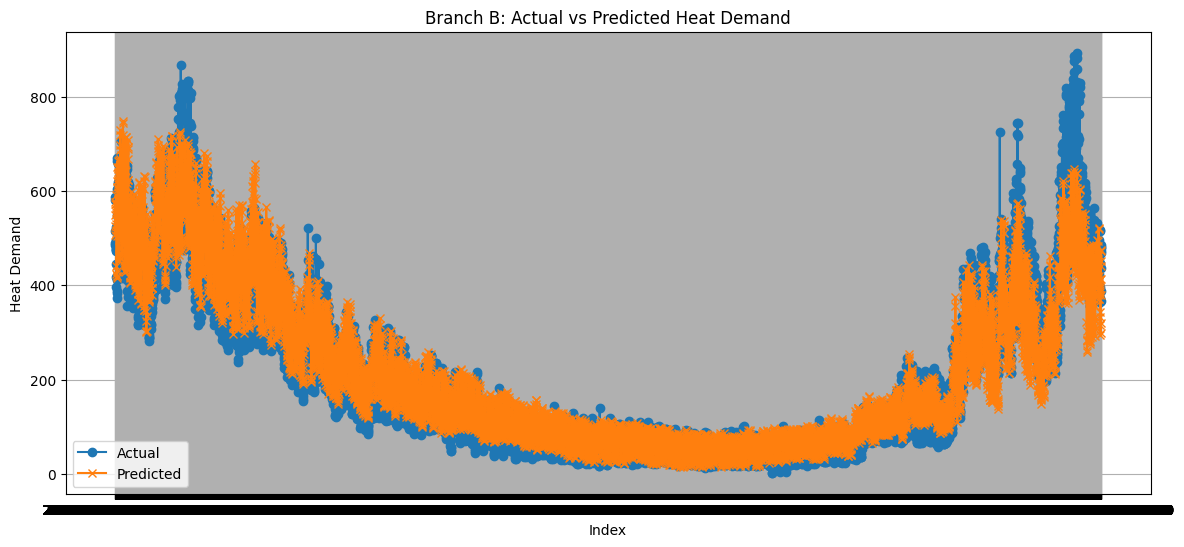

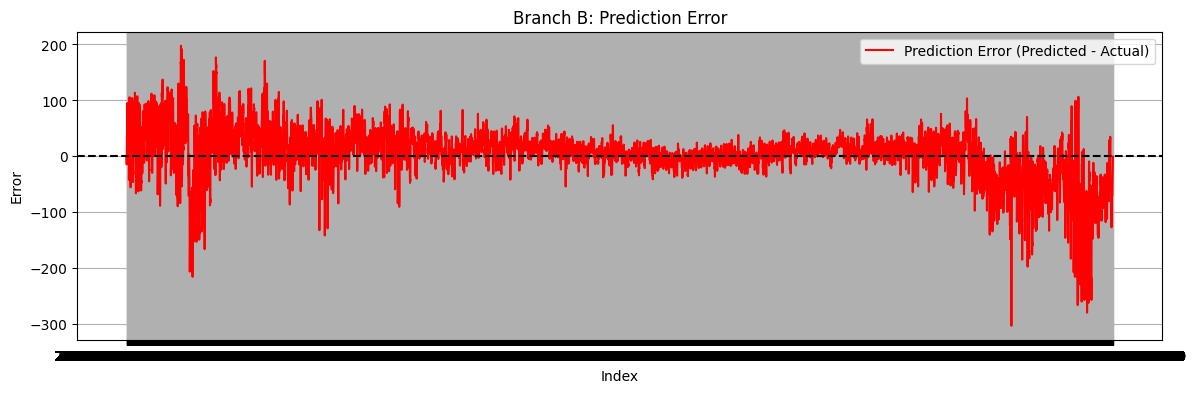

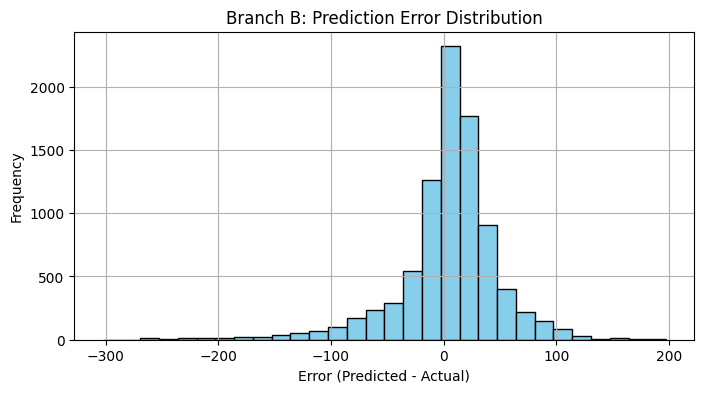

각 Fold의 Validation RMSE: [np.float64(95.69865919417322), np.float64(28.150961172961228)]
최종 평균 Validation RMSE: 61.924810183567224


In [13]:
# 1. branch_id가 'B'인 데이터만 추출
branch = 'B'
train_branch = df_train[df_train['branch_id'] == branch].copy()
test_branch = df_test[df_test['branch_id'] == branch].copy()

# branch_id 컬럼 제거 (모델 입력에 불필요)
train_branch = train_branch.drop(columns=['branch_id'])
test_branch = test_branch.drop(columns=['branch_id'])

target_col = 'heat_demand'

# 2. 예측 수행
results = run_3fold_pipeline_with_ridge_ensemble(train_branch, test_branch, target_col)

# 3. 예측 결과 DataFrame 생성 (index 기준)
test_pred_B = pd.DataFrame({
    'branch_ID': branch,
    'heat_demand': results['test_pred']
}, index=results['test_index'])

# 4. 실제값과 예측값 비교를 위한 df_test_B 준비 (index 기준)
df_test_B = df_test[df_test['branch_id'] == branch].copy()
df_test_B = df_test_B.sort_index()
test_pred_B = test_pred_B.sort_index()

# 5. 공통 인덱스만 사용해서 비교 (NaN 방지)
common_index = df_test_B.index.intersection(test_pred_B.index)
compare_df = df_test_B.loc[common_index, ['heat_demand']].rename(columns={'heat_demand': 'actual'})
compare_df['predicted'] = test_pred_B.loc[common_index, 'heat_demand']
compare_df['diff'] = compare_df['predicted'] - compare_df['actual']

# 6. NaN이 남아있으면 제거
compare_df = compare_df.dropna()

# 7. RMSE, MAE 계산
rmse = np.sqrt(np.mean(compare_df['diff'] ** 2))
mae = np.mean(np.abs(compare_df['diff']))
print(f"Branch B - RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# 8. 실제값 vs 예측값 시각화
plt.figure(figsize=(14, 6))
plt.plot(compare_df.index, compare_df['actual'], label='Actual', marker='o')
plt.plot(compare_df.index, compare_df['predicted'], label='Predicted', marker='x')
plt.title('Branch B: Actual vs Predicted Heat Demand')
plt.xlabel('Index')
plt.ylabel('Heat Demand')
plt.legend()
plt.grid(True)
plt.show()

# 9. 오차 시계열 시각화
plt.figure(figsize=(14, 4))
plt.plot(compare_df.index, compare_df['diff'], label='Prediction Error (Predicted - Actual)', color='red')
plt.axhline(0, color='black', linestyle='--')
plt.title('Branch B: Prediction Error')
plt.xlabel('Index')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

# 10. 오차 분포 히스토그램
plt.figure(figsize=(8, 4))
plt.hist(compare_df['diff'], bins=30, color='skyblue', edgecolor='black')
plt.title('Branch B: Prediction Error Distribution')
plt.xlabel('Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print("각 Fold의 Validation RMSE:", results['val_rmses'])
print("최종 평균 Validation RMSE:", results['val_rmse'])


